# Benchmarks analysis

This notebook aims to assess our model's performances on two synthetic benchkmarks of abnormalities:
- deletion benchmark: simple surfaces of various sizes have been randomly deleted
- asymmetry benchmark: equivalent crop but on left hemisphere and then flipped

In [5]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [6]:
if torch.cuda.is_available():
    device = "cuda:0"

In [10]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_75_kl_2/checkpoint.pt'
model = VAE((1, 80, 80, 96), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [7]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))

### Loading of deletion benchmark

In [8]:
data_dir = "/neurospin/dico/lguillon/distmap/benchmark/deletion"
data_path = "crops/1mm/SC"

In [9]:
distmaps_200 = np.load(os.path.join(data_dir, "200", data_path, "200_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", data_path, "sub_id.npy"))

subset_200 = SkeletonDataset(dataframe=distmaps_200,
                         filenames=filenames_200,
                         data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", data_path, "500_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", data_path, "sub_id.npy"))

subset_500 = SkeletonDataset(dataframe=distmaps_500,
                         filenames=filenames_500,
                         data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", data_path, "700_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", data_path, "sub_id.npy"))

subset_700 = SkeletonDataset(dataframe=distmaps_700,
                         filenames=filenames_700,
                         data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", data_path, "1000_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", data_path, "sub_id.npy"))

subset_1000 = SkeletonDataset(dataframe=distmaps_1000,
                         filenames=filenames_1000,
                         data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [11]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

200


KeyboardInterrupt: 

In [ ]:
df_encoded_deletion = pd.DataFrame()
df_encoded_deletion['latent'] = encoded_deletion['200'] +encoded_deletion['500']+ encoded_deletion['700'] +encoded_deletion['1000']  
df_encoded_deletion['loss'] = losses_deletion['200'] + losses_deletion['500'] + losses_deletion['700'] + losses_deletion['1000'] 
df_encoded_deletion['recon'] = recon_deletion['200'] + recon_deletion['500'] +recon_deletion['700'] + recon_deletion['1000']  
df_encoded_deletion['input'] = input_deletion['200'] + input_deletion['500'] + input_deletion['700'] + input_deletion['1000']
df_encoded_deletion['sub'] = list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000)

In [ ]:
deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

In [ ]:
deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

In [ ]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub')
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub')
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [ ]:
len(deletion_all)

In [ ]:
deletion_all['sub']

### Benchmark 200

In [181]:
random_ctrl = random.sample(list(df_encoded_hcp['sub'][:200]), 100)

In [182]:
random_deletion = list(set(list(deletion_200['sub'].astype(int))) - set(random_ctrl))

In [183]:
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(random_deletion)]
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [186]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_200_X['latent']))

from sklearn.manifold import TSNE
X_embedded_200 = TSNE(n_components=2).fit_transform(X_all)
labels_200 = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(len(df_encoded_200_X))])

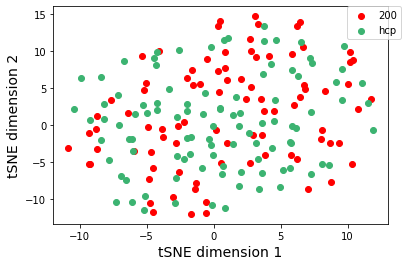

In [187]:
arr = X_embedded_200
color_dict = {'hcp':'mediumseagreen', '200': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### Benchmark 500

In [178]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'])) - set(list(deletion_500['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [179]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_500_X['latent']))

X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
labels_500 = np.array(list(df_encoded_hcp_X['Group']) + ['500' for k in range(len(df_encoded_500_X))])

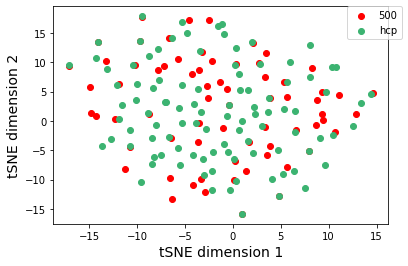

In [180]:
arr = X_embedded_500
color_dict = {'hcp':'mediumseagreen', '500': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### Benchmark 700

In [167]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [174]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_700_X['latent']))

X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X['Group']) + ['700' for k in range(len(df_encoded_700_X))])

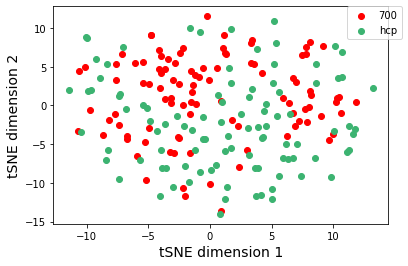

In [175]:
arr = X_embedded_700
color_dict = {'hcp':'mediumseagreen', '700': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### Benchmark 1000

In [158]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [165]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_1000_X['latent']))

X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])

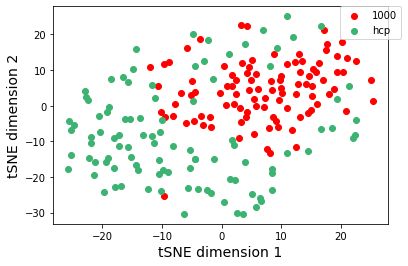

In [166]:
arr = X_embedded_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [157]:
len(df_encoded_hcp_X['sub'])

100

In [56]:
len(list(df_encoded_hcp['sub'].astype(str)) + list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000))

714

In [20]:
X_200 = np.array(list(df_encoded_200['latent']))
X_hcp = np.array(list(df_encoded_hcp['latent']))
X_all = np.array(list(df_encoded_200['latent']) + list(df_encoded_hcp['latent']))

from sklearn.manifold import TSNE
X_embedded_200 = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_all)

In [24]:
labels_200 = np.array(list(df_encoded_hcp['Group']) + ['200' for k in range(len(filenames_200))])

KeyError: 'scint'

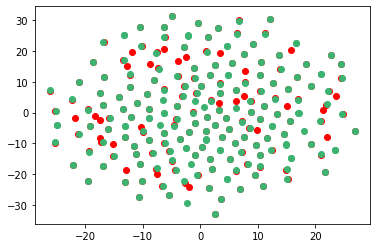

In [27]:
arr = X_embedded_200
color_dict = {'hcp':'mediumseagreen', '200': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [28]:
len(X_hcp)

207

In [36]:
len(filenames_200)

180

In [35]:
len(set(list(df_encoded_hcp['sub'].astype(str))) -set(filenames_200))

27